In [1]:
from torchvision import datasets, transforms
from torch.utils import data

In [2]:
train_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=True, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)

test_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=False, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)

In [3]:
images, labels = next(iter(train_loader))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f

In [5]:
torch.manual_seed(14) # 시드
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
device

device(type='cuda')

# ANN 모델 정의

In [6]:
# 모델 정의는 클래스 형태로 정의
class Ann(nn.Module):
    def __init__(self):
        super(Ann, self).__init__()
        self.fc1 = nn.Linear(784, 256) # input layer, 784 = 28*28
        self.fc2 = nn.Linear(256, 128) # hidden layer
        self.fc3 = nn.Linear(128, 10) # output layer
    
    def forward(self, x): # 정방향 연산 (입력->출력)
        x = x.view(-1, 784) # 1차원으로 펼치기
        x = f.relu(self.fc1(x)) # relu 활성화 함수
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Ann().to(device) # 모델의 파라미터들을 지정한 장치의 메모리로 전달

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
# 학습하기 전 model이 train할 수 있도록 train mode로 변환
model.train()

Ann(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
data, target = images.to(device), labels.to(device) # 추출한 batch 데이터 1개를 device에 전달
data.shape, target.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
optimizer.zero_grad() # 기울기 초기화 - 새로운 최적화 값을 찾기 위해 준비

In [12]:
output = model(data)

In [13]:
# output과 target의 오차 계산
# 오차에 최적화 알고리즘을 통해 가중치를 줄여나가는 함수
loss = f.cross_entropy(output, target)

In [14]:
loss.backward() # 기울기 계산

In [15]:
# 기울기를 가중치로 수정
optimizer.step()

# 학습

In [16]:
EPOCHS = 10

In [17]:
model = Ann().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [18]:
for epoch in range(1, EPOCHS+1):
    model.train()
    # 학습 데이터를 배치 사이즈만큼 반복
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train Epoch: {epoch}\tLoss:{loss.item():.6f}')

Train Epoch: 1	Loss:0.652915
Train Epoch: 2	Loss:0.536123
Train Epoch: 3	Loss:0.462021
Train Epoch: 4	Loss:0.399988
Train Epoch: 5	Loss:0.346333
Train Epoch: 6	Loss:0.305049
Train Epoch: 7	Loss:0.275873
Train Epoch: 8	Loss:0.258256
Train Epoch: 9	Loss:0.240978
Train Epoch: 10	Loss:0.230121


# 성능 평가

In [19]:
EPOCHS = 10
model = Ann().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
train_history = []
test_history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    # 학습 데이터를 배치 사이즈만큼 반복
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train Epoch: {epoch}\tLoss:{loss.item():.6f}')
    train_history.append(loss.item())
    
    model.eval() # 검증 모드
    
    test_loss = 0 # 테스트 데이터 오차
    correct = 0 # 정답 수
    
    with torch.no_grad(): # 평가 때는 기울기 계산 필요 없음
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # dim=1: 차원, keepdim=True: 차원 유지
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_history.append(test_loss)

    print(f'Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct/len(test_loader.dataset)*100:.0f}%\n')

Train Epoch: 1	Loss:0.656011
Test set: Average Loss: 0.5371, Accuracy: 80%

Train Epoch: 2	Loss:0.539279
Test set: Average Loss: 0.4761, Accuracy: 83%

Train Epoch: 3	Loss:0.463598
Test set: Average Loss: 0.4455, Accuracy: 84%

Train Epoch: 4	Loss:0.412238
Test set: Average Loss: 0.4248, Accuracy: 85%

Train Epoch: 5	Loss:0.366006
Test set: Average Loss: 0.4095, Accuracy: 85%

Train Epoch: 6	Loss:0.321762
Test set: Average Loss: 0.3983, Accuracy: 86%

Train Epoch: 7	Loss:0.288978
Test set: Average Loss: 0.3892, Accuracy: 86%

Train Epoch: 8	Loss:0.268829
Test set: Average Loss: 0.3803, Accuracy: 87%

Train Epoch: 9	Loss:0.254075
Test set: Average Loss: 0.3732, Accuracy: 87%

Train Epoch: 10	Loss:0.240055
Test set: Average Loss: 0.3666, Accuracy: 87%



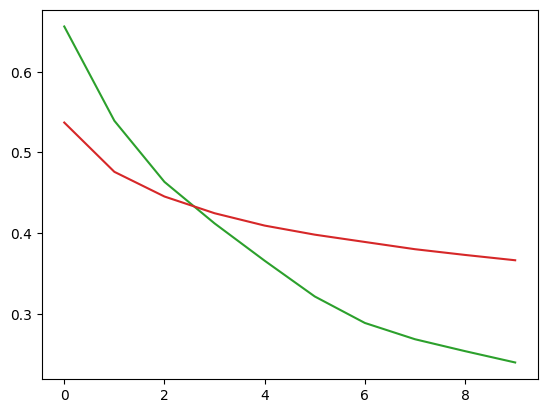

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_history, color='tab:green')
plt.plot(test_history, color='tab:red')
plt.show()

# 성능 개선
과적합 해결 방법
- 데이터 정규화
    - Normalize 옵션 사용
    - 평균과 표준편차 값을 지정해서 정규화
- Dropout
    - 신경망의 일부를 사용하지 않음
    - 개별 뉴런의 연산 결과에 가중치가 고정되는 현상 방지
- 데이터 더 모으기
    - 데이터를 일부 변형하여 개수 증가

In [27]:
from torch.utils import data

train_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=True, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.RandomHorizontalFlip(), # 랜덤으로 좌우 변경하여 데이터 수 2배 증가
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)

# 테스트 데이터는 그대로 사용
test_loader = data.DataLoader(
    datasets.FashionMNIST('dataset/', train=False, download=True, # 다운로드 경로
                         transform=transforms.Compose([ # 이미지를 텐서로 바꿔주는 코드
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,), std=(0.5,))
                         ])
                         ),
    batch_size=32
)

In [28]:
# 모델 정의는 클래스 형태로 정의
class Ann(nn.Module):
    def __init__(self, dropout=0.2):
        super(Ann, self).__init__()
        self.fc1 = nn.Linear(784, 256) # input layer, 784 = 28*28
        self.fc2 = nn.Linear(256, 128) # hidden layer
        self.fc3 = nn.Linear(128, 10) # output layer
        self.dropout = dropout
    
    def forward(self, x): # 정방향 연산 (입력->출력)
        x = x.view(-1, 784) # 1차원으로 펼치기
        x = f.relu(self.fc1(x)) # relu 활성화 함수
        x = f.relu(self.fc2(x))
        x = f.dropout(x, training=self.training, p=self.dropout) # dropout 추가
        x = self.fc3(x)
        return x

In [29]:
EPOCHS = 30
model = Ann(dropout=0.2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [30]:
train_history = []
test_history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    # 학습 데이터를 배치 사이즈만큼 반복
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train Epoch: {epoch}\tLoss:{loss.item():.6f}')
    train_history.append(loss.item())
    
    model.eval() # 검증 모드
    
    test_loss = 0 # 테스트 데이터 오차
    correct = 0 # 정답 수
    
    with torch.no_grad(): # 평가 때는 기울기 계산 필요 없음
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # dim=1: 차원, keepdim=True: 차원 유지
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_history.append(test_loss)

    print(f'Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct/len(test_loader.dataset)*100:.0f}%\n')

Train Epoch: 1	Loss:0.768441
Test set: Average Loss: 0.5895, Accuracy: 79%

Train Epoch: 2	Loss:0.529995
Test set: Average Loss: 0.5110, Accuracy: 82%

Train Epoch: 3	Loss:0.473318
Test set: Average Loss: 0.4740, Accuracy: 83%

Train Epoch: 4	Loss:0.455224
Test set: Average Loss: 0.4499, Accuracy: 84%

Train Epoch: 5	Loss:0.428077
Test set: Average Loss: 0.4300, Accuracy: 84%

Train Epoch: 6	Loss:0.365961
Test set: Average Loss: 0.4202, Accuracy: 85%

Train Epoch: 7	Loss:0.377197
Test set: Average Loss: 0.4029, Accuracy: 85%

Train Epoch: 8	Loss:0.310970
Test set: Average Loss: 0.3967, Accuracy: 86%

Train Epoch: 9	Loss:0.287455
Test set: Average Loss: 0.3853, Accuracy: 86%

Train Epoch: 10	Loss:0.280414
Test set: Average Loss: 0.3798, Accuracy: 86%

Train Epoch: 11	Loss:0.240062
Test set: Average Loss: 0.3768, Accuracy: 86%

Train Epoch: 12	Loss:0.247113
Test set: Average Loss: 0.3679, Accuracy: 87%

Train Epoch: 13	Loss:0.236698
Test set: Average Loss: 0.3651, Accuracy: 87%

Train Ep

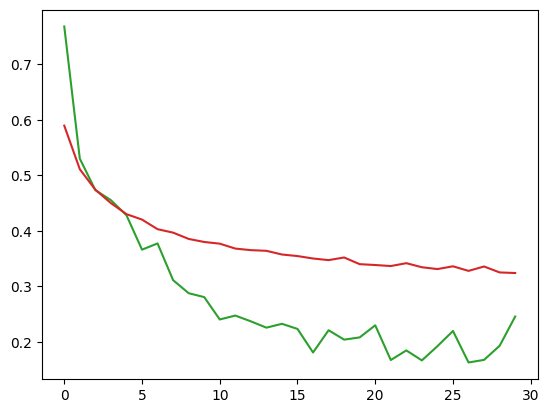

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_history, color='tab:green')
plt.plot(test_history, color='tab:red')
plt.show()